# import

In [549]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter# счетчик

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [550]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [551]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [552]:
DATA_DIR = r'C:\Projects\awesome-website\skillfactory-module_0-Mikheev\Lessons\Проект 3. О вкусной и здоровой пище\data'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [553]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

**Немного изменим названия столбцов для удобства**

In [554]:
col = ['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Price_Range', 'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA','sample','Rating']
data.columns = col

In [555]:
data.info(100000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine_Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price_Range        32639 non-null  object 
 5   Number_of_Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 2.9+ MB


In [556]:
data

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0


# Cleaning and Prepping Data

**Проверяем столбец с Restaurant_id (идентификационный номер ресторана / сети ресторанов)**

In [557]:
data['Restaurant_id'].value_counts()
# пропусков нет, все ок

id_436      19
id_633      19
id_227      19
id_871      19
id_534      18
            ..
id_10016     1
id_10695     1
id_13389     1
id_8165      1
id_9507      1
Name: Restaurant_id, Length: 13094, dtype: int64

In [558]:
print(data['Restaurant_id'].describe())
# по условию - в одному id  могут быть прикреплены несколько ресторанов одной сети,
# поэтому уникальных значений меньше чем записей

count      50000
unique     13094
top       id_436
freq          19
Name: Restaurant_id, dtype: object


In [559]:
data['Restaurant_id'] = [i[3:] for i in data['Restaurant_id']]
data['Restaurant_id'] = [int(i) for i in data['Restaurant_id']]

print(' ')
print(len(data['Restaurant_id']))
print(type(data['Restaurant_id'][1]))

# превратили столбец в численное выражение

 
50000
<class 'numpy.int64'>


**Добавляем количество заведений в сети**

In [560]:
a=data['Restaurant_id'].value_counts()
a=dict(a)
a=pd.DataFrame({'count':a}, columns=['count'])

A=a.index
B=a.values

data['chain']= data['Restaurant_id'].replace(A, B)
data[['Restaurant_id', 'chain']]

,Restaurant_id,chain
0,0,16
1,1,10
2,2,15
3,3,9
4,4,14
...,...,...
49995,499,15
49996,6340,3
49997,1649,11
49998,640,9


**Проверяем столбец с City (город, в котором находится ресторан)**

In [561]:
data.City.value_counts()
# пропусков нет, города не повторяются, проблем с ракладкой или регистром нет, все ок

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [562]:

print(data.City.describe())

count      50000
unique        31
top       London
freq        7193
Name: City, dtype: object


In [563]:
#преобразуем City в переменную dummy
data = pd.concat((data, pd.get_dummies(data.City)), axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  int64  
 1   City               50000 non-null  object 
 2   Cuisine_Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price_Range        32639 non-null  object 
 5   Number_of_Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  chain              50000 non-null  int64  
 12  Amsterdam          50000 non-null  uint8  
 13  Athens             50000 non-null  uint8  
 14  Barcelona          50000 non-null  uint8  
 15  Berlin             50000 non-null  uint8  
 16  Bratislava         500

Сделаем "нормализацию" значения рейтинга по городам

In [564]:
A = list(data.City.value_counts().keys())
data1=pd.DataFrame()
data1['City'] = data['City']
data1['Ranking']=data['Ranking']
data1=pd.DataFrame(data1.groupby(['City']).max())
data2=data1['Ranking']
A=list(data2.keys())
B=list(data2)

data['Len_rest_in_city'] = data['City'].replace(A, B)

data['Std_ranking']=data['Ranking']/data['Len_rest_in_city']

data.Std_ranking.describe()

count    50000.000000
mean         0.498423
std          0.287871
min          0.000061
25%          0.249061
50%          0.496908
75%          0.747353
max          1.000000
Name: Std_ranking, dtype: float64

In [565]:
data2

City
Amsterdam      3254.0
Athens         1787.0
Barcelona      7796.0
Berlin         6372.0
Bratislava      889.0
Brussels       3006.0
Budapest       2440.0
Copenhagen     1964.0
Dublin         1960.0
Edinburgh      1766.0
Geneva         1413.0
Hamburg        2737.0
Helsinki       1141.0
Krakow         1244.0
Lisbon         3717.0
Ljubljana       468.0
London        16444.0
Luxembourg      621.0
Lyon           2666.0
Madrid         8809.0
Milan          6275.0
Munich         2763.0
Oporto         1484.0
Oslo           1137.0
Paris         13986.0
Prague         4188.0
Rome           5948.0
Stockholm      2464.0
Vienna         3444.0
Warsaw         2154.0
Zurich         1601.0
Name: Ranking, dtype: float64

**Добавим столбец Population (кол-во жителей в каждом городе)**

In [566]:
number_city_residents_dict = {'Paris':2148327, 'Stockholm':961609, 'London':8908081, 'Berlin':3644826, 'Munich':1471508, 'Oporto':237591,
       'Milan':1378689, 'Bratislava':437725, 'Vienna':1897491, 'Rome':2870500, 'Barcelona':1636762, 'Madrid':3266126,
       'Dublin':1173179, 'Brussels':179277, 'Zurich':428737, 'Warsaw':1790658, 'Budapest':1752286, 'Copenhagen':615993,
       'Amsterdam':872757, 'Lyon':506615, 'Hamburg':1841179, 'Lisbon':505526, 'Prague':1301132, 'Oslo':673469,
       'Helsinki':655281, 'Edinburgh':488100, 'Geneva':200548, 'Ljubljana':284355, 'Athens':664046,
       'Luxembourg':602005, 'Krakow':769498}
# словарь со кол-вом жителей
data['population'] = data['City'].replace(number_city_residents_dict)
print(len(data.population))
print(type(data.population[1]))

50000
<class 'numpy.int64'>


**Добавим столбец Country (страна)**

In [567]:
country_dict = {'London': 'GreatBritain', 'Paris': 'France', 'Madrid': 'Spain', 'Barcelona': 'Spain', 
                'Berlin': 'Germany', 'Milan': 'Italy', 'Rome': 'Italy', 'Prague': 'CzechRepublic', 
                'Lisbon': 'Portugal', 'Vienna': 'Austria', 'Amsterdam': 'Netherlands', 'Brussels': 'Belgium', 
                'Hamburg': 'Germany', 'Munich': 'Germany', 'Lyon': 'France', 'Stockholm': 'Sweden', 
                'Budapest': 'Hungary', 'Warsaw': 'Poland', 'Dublin': 'Irland', 'Copenhagen': 'Denmark', 
                'Athens': 'Greece', 'Edinburgh': 'Scotland', 'Zurich': 'Switzeland', 'Oporto': 'Portugal', 
                'Geneva': 'Switzeland', 'Krakow': 'Poland', 'Oslo': 'Norway', 'Helsinki': 'Finland', 
                'Bratislava': 'Slovakia', 'Luxembourg': 'Luxembourg', 'Ljubljana': 'Slovenia'
}
# словарь города-страны

data['Country'] = data.City.replace(country_dict)
print(data.Country.value_counts())

A = list(data.Country.value_counts().keys())
B = range(0, len(A))
dict_country = dict(zip(A, B))
# словарь со значениями стран


data['Country_ind'] = data['Country'].replace(A, B)

print(len(data.Country_ind))
print(type(data.Country_ind[1]))

France           7234
Spain            7208
GreatBritain     7193
Italy            5283
Germany          5036
Portugal         2289
CzechRepublic    1816
Poland           1479
Austria          1443
Netherlands      1372
Belgium          1314
Switzeland       1275
Sweden           1033
Hungary          1021
Irland            836
Denmark           819
Greece            776
Scotland          745
Norway            488
Finland           475
Slovakia          380
Luxembourg        263
Slovenia          222
Name: Country, dtype: int64
50000
<class 'numpy.int64'>


**Добавим столбик с отношением кол-ва отзывов к населению (как часто пишут их)**

In [568]:
data['rew_on_pop'] = data['Number_of_Reviews']/data['population']
data['rew_on_pop'] = data['rew_on_pop'].fillna(0)

print(len(data.rew_on_pop))
print(type(data.rew_on_pop[1]))

50000
<class 'numpy.float64'>


**Проверяем столбец с Cuisine_Style (кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане)**

In [569]:
# # сформируем список достаточно уникальных кухонь и сформируем на его основе новый признак
# list_of_unique_Cuisine = [x[0] for x in temp_counter.most_common()[-16:]]
# data['unique_Cuisine_Style'] = data['Cuisine_Style'].apply(lambda x: 1 if len(set(x) & set(list_of_unique_Cuisine))>0  else 0).astype('float64')

In [570]:
len(data[data['Cuisine_Style'].isna()])

11590

In [571]:
# в переменной 11590 (23.2%) пропущенных значений 
# сохраним эту информацию
data['NAN_Cuisine Style'] = pd.isna(data['Cuisine_Style']).astype('float64') 


data['Cuisine_Style'] = data['Cuisine_Style'].fillna("['No_info']")
# заменяем пропуски

# закодируем значения в переменной до их преобразования
le = LabelEncoder()
le.fit(data['Cuisine_Style'])
data['code_Cuisine Style'] = le.transform(data['Cuisine_Style'])

In [572]:
# проведем обработку значений переменной
data['Cuisine_Style'] = data['Cuisine_Style'].str.findall(r"'(\b.*?\b)'")

temp_list = data['Cuisine_Style'].tolist()

def list_unrar(list_of_lists):
    # функция создает общий список стилей кухни
    result=[]
    for lst in list_of_lists:
        result.extend(lst)
    return result

# создаем счетчик стилей кухни
coun=Counter(list_unrar(temp_list))



# сформируем список достаточно уникальных кухонь и сформируем на его основе новый признак
list_of_unique_Cuisine = [x[0] for x in coun.most_common()[-16:]]
data['unique_Cuisine_Style'] = data['Cuisine_Style'].apply(lambda x: 1 if len(set(x) & set(list_of_unique_Cuisine))>0  else 0).astype('float64')

data['Cuisine_Style2'] = data['Cuisine_Style']

# coun = Counter(b)  # подсчитываем количество каждого стиля кухни
coun = dict(coun)
coun = pd.DataFrame({'count': coun}, columns=['count'])
# находим среднее количество используемых стилей кухни
a = coun['count'].mean()

b = set(coun.query('count > @a').index)
# оставляем только самые популярные кухни

c = set(coun.index) - b
# находим непопулярные кухни

cus_st = pd.DataFrame(data['Cuisine_Style2'].to_list()).stack()
for item in c:
    cus_st = cus_st.replace(item, 'other_cuisine_style')
cus_st = cus_st.groupby(level=[0]).apply(",".join).reset_index()
data['Cuisine_Style'] = cus_st[0]
# заменяем непопулярные кухни на 'other'


b.add('other_cuisine_style')

def find_item(cell):
    if item in cell:
        return 1
    return 0


for item in b:
    data[item] = data['Cuisine_Style'].apply(find_item).astype(np.uint8)
# преобразуем в dummy переменную


data['count_Cuisine_Style'] = data['Cuisine_Style2'].apply(lambda x: len(x))
# подсчитываем количество используемых стилей кухни в ресторане

print(len(data['Cuisine_Style']))
print(len(data['count_Cuisine_Style']))
# пропуски заменены, строки преобразованы в столбцы

50000
50000


In [573]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 80 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant_id         50000 non-null  int64  
 1   City                  50000 non-null  object 
 2   Cuisine_Style         50000 non-null  object 
 3   Ranking               50000 non-null  float64
 4   Price_Range           32639 non-null  object 
 5   Number_of_Reviews     46800 non-null  float64
 6   Reviews               49998 non-null  object 
 7   URL_TA                50000 non-null  object 
 8   ID_TA                 50000 non-null  object 
 9   sample                50000 non-null  int64  
 10  Rating                50000 non-null  float64
 11  chain                 50000 non-null  int64  
 12  Amsterdam             50000 non-null  uint8  
 13  Athens                50000 non-null  uint8  
 14  Barcelona             50000 non-null  uint8  
 15  Berlin             

**Проверяем столбец с Price_Range (диапазон цен в ресторане)**

In [574]:
print(data.Price_Range.describe())

count        32639
unique           3
top       $$ - $$$
freq         23041
Name: Price_Range, dtype: object


In [575]:
price_dict ={'$':1, '$$ - $$$':2, '$$$$':3}
data['price_rank'] = data['Price_Range'].replace(price_dict)
# делаем замену текста на числа

price_mode = data['price_rank'].mode()
data['price_rank'].fillna(int(price_mode), inplace=True)
# пропущенные значения заменяем самой частой величиной

print('')
print(len(data.price_rank))
print(type(data.price_rank[1]))
# заменили буквенные индефикаторы на численные


50000
<class 'numpy.float64'>


**Проверяем столбец с Reviews (данные о двух отзывах, которые отображаются на сайте ресторана)**

In [576]:
print(data.Reviews.describe())

count        49998
unique       41857
top       [[], []]
freq          8112
Name: Reviews, dtype: object


In [577]:
from datetime import datetime, date, time
data['Reviews'] = data.Reviews.replace("[[], []]", 'No_info')
# заменяем пропуски

In [578]:
data['Last_rew'] = data['Reviews']

data['Last_rew']=data['Last_rew'].str[-27:-17]

now = datetime.now()

In [579]:
data['Last_rew']

0                  
1        12/05/2017
2        12/28/2017
3        12/06/2017
4        02/08/2018
            ...    
49995    12/16/2017
49996    12/21/2017
49997    11/03/2016
49998    07/11/2017
49999    01/31/2016
Name: Last_rew, Length: 50000, dtype: object

In [580]:
#base['Last_rew'][base.Last_rew.str.contains("]")]=now
data['Last_rew'][data.Last_rew.str.contains("]")==True] = '01/01/2000'
data['Last_rew'] = data['Last_rew'].fillna('01/01/2000')

<ipython-input-580-b5efd9320d8b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Last_rew'][data.Last_rew.str.contains("]")==True] = '01/01/2000'


In [581]:
data['Last_rew'] = data['Last_rew'].apply(pd.to_datetime) 

In [582]:
data['Last_rew_data'] = now - data['Last_rew']

In [583]:
data['Last_rew_data'] = data['Last_rew_data'].apply(lambda x: x.total_seconds())# [i.total_seconds() for i in data.Last_rew_data]

In [584]:
data['Last_rew_data'] = data['Last_rew_data'].fillna(data['Last_rew_data'].max())
data['Last_rew_data'] = data['Last_rew_data'].astype(np.int64)
print('')
print(len(data.Last_rew_data))
print(type(data.Last_rew_data[1]))


50000
<class 'numpy.int64'>


**Проверяем столбец с Number_of_Reviews (количество отзывов о ресторане)**

In [585]:
m=data['Number_of_Reviews'].mean()
print(data['Number_of_Reviews'].describe())
# отрицательных чисел нет

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number_of_Reviews, dtype: float64


In [586]:

data['Number_of_Reviews'].value_counts()
# но есть пропуски, нужно проверить, что где есть пропуски - там действительно нет отзывов

2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: Number_of_Reviews, Length: 1573, dtype: int64

In [587]:
data['Number_of_Reviews'] = data['Number_of_Reviews'].fillna('No_info')
# меняем пропуски на Not_info

In [588]:
a = data.query('Reviews == "No_info" & Number_of_Reviews == "No_info"')
b = list(a.index)
data['Number_of_Reviews'][b] = 0
# где нет значения кол-ва отзывов и превью отзывов - ставим 0

<ipython-input-588-7b6a50cd5b63>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Number_of_Reviews'][b] = 0
c:\users\пользователь\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [589]:
len(data['Number_of_Reviews'])
# заменили предполагаемые пропуски

50000

In [590]:
data['Number_of_Reviews'] = data['Number_of_Reviews'].replace('No_info', m)

# пропуски, которые не смогли заполнить, заполняем медианным значением

print('')
print(len(data.Number_of_Reviews))
print(type(data.Number_of_Reviews[1]))


50000
<class 'numpy.float64'>


**Добавляем столбик с отношением кол-ва отзывов по одному ресторану к общему кол-ву отзывов по городу**

In [591]:
A = list(data.City.value_counts().keys())
data1=pd.DataFrame()
data1['City'] = data['City']
data1['Number_of_Reviews']=data['Number_of_Reviews']

In [592]:
data2=pd.DataFrame(data1.groupby(['City']).sum())
data2=data2['Number_of_Reviews']
A=list(data2.keys())
B=list(data2)


In [593]:
data['Len_rew'] = data['City'].replace(A, B)

data['Std_num_rew']=data['Number_of_Reviews']/data['Len_rew']

**проверяем м столбец с ID_TA (идентификатор ресторана в базе данных TripAdvisor)**

In [594]:
print(data['ID_TA'].describe())

count        50000
unique       49963
top       d9877640
freq             2
Name: ID_TA, dtype: object


In [595]:
data['ID_TA']=data['ID_TA'].str[1:]
data.ID_TA = [float(i) for i in data.ID_TA]

In [596]:
print('')
print(len(data.ID_TA))
print(type(data.ID_TA[1]))


50000
<class 'numpy.float64'>


<AxesSubplot:>

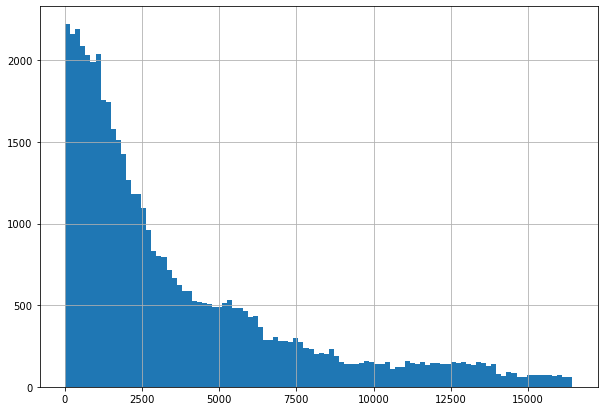

In [597]:
plt.rcParams['figure.figsize'] = (10,7)
data['Ranking'].hist(bins=100)

<AxesSubplot:>

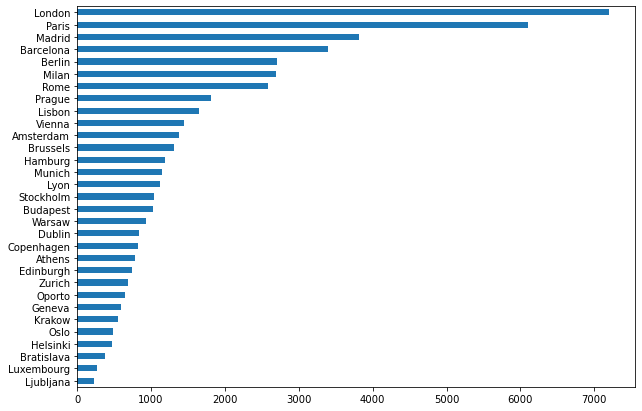

In [598]:
data['City'].value_counts(ascending=True).plot(kind='barh')

<AxesSubplot:>

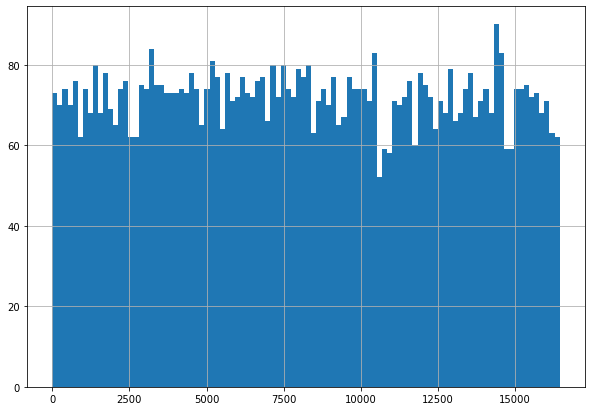

In [599]:
data['Ranking'][data['City'] =='London'].hist(bins=100)

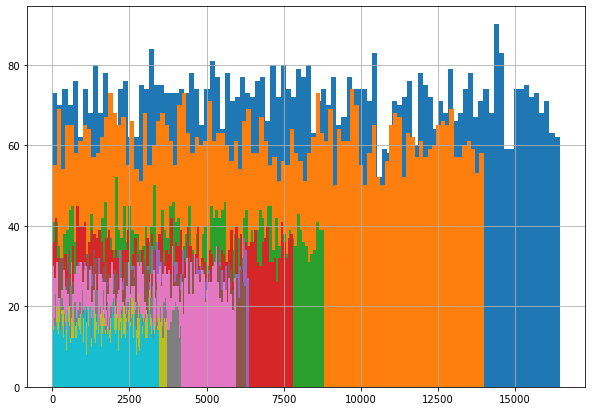

In [600]:
# посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

<AxesSubplot:>

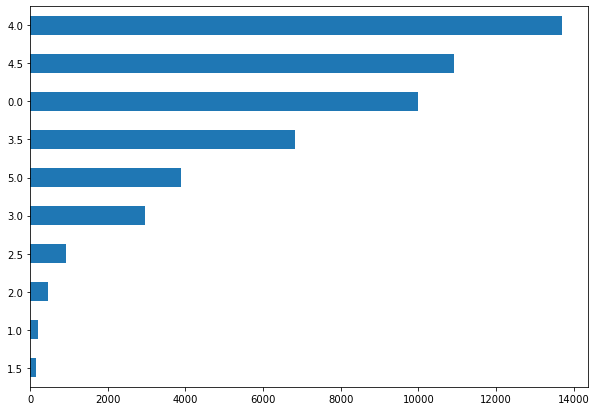

In [601]:
data['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

<AxesSubplot:>

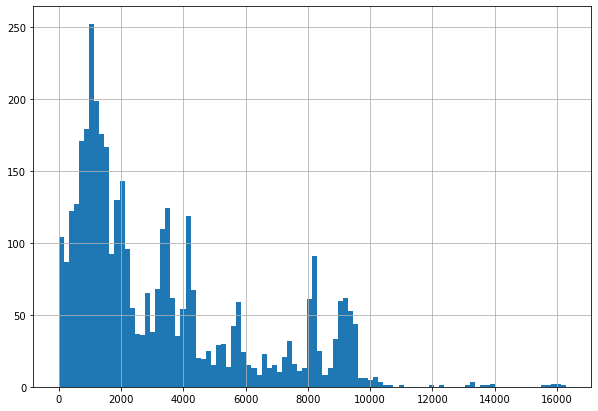

In [602]:
data['Ranking'][data['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

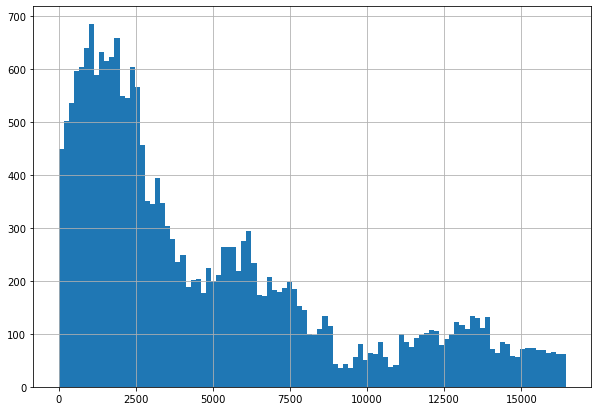

In [603]:
data['Ranking'][data['Rating'] < 4].hist(bins=100)

<AxesSubplot:>

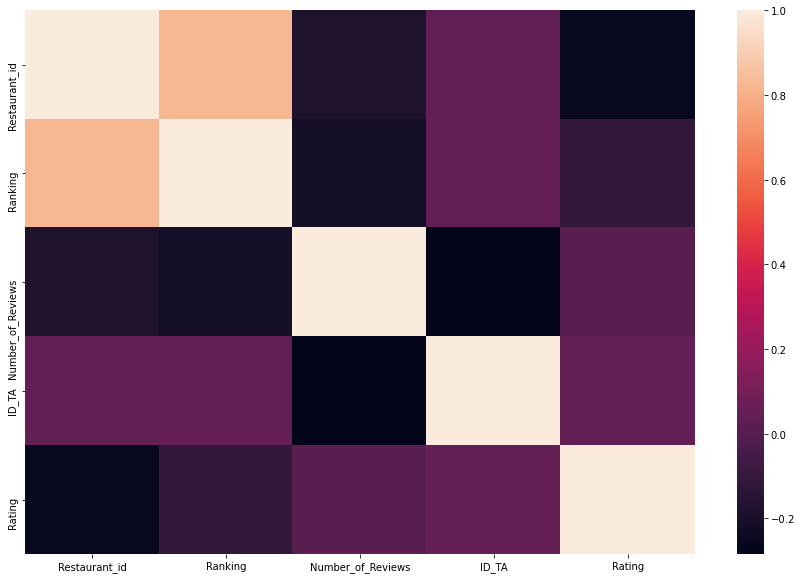

In [604]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data[col].drop(['sample'], axis=1).corr(),)

# Data Preprocessing

**Удалим все ненужные или неполезные столбики, которые портят нам результат**

In [605]:
data = data.drop('URL_TA', axis=1)
data = data.drop('Reviews', axis=1)
data = data.drop('Last_rew', axis=1)
data = data.drop('City', axis=1)
data = data.drop('Country', axis=1)
data = data.drop('Restaurant_id', axis=1)
data = data.drop('chain', axis=1)
data = data.drop('Cuisine_Style', axis=1)
data = data.drop('Cuisine_Style2', axis=1)
data = data.drop('Price_Range', axis=1)


In [606]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 75 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Ranking               50000 non-null  float64
 1   Number_of_Reviews     50000 non-null  float64
 2   ID_TA                 50000 non-null  float64
 3   sample                50000 non-null  int64  
 4   Rating                50000 non-null  float64
 5   Amsterdam             50000 non-null  uint8  
 6   Athens                50000 non-null  uint8  
 7   Barcelona             50000 non-null  uint8  
 8   Berlin                50000 non-null  uint8  
 9   Bratislava            50000 non-null  uint8  
 10  Brussels              50000 non-null  uint8  
 11  Budapest              50000 non-null  uint8  
 12  Copenhagen            50000 non-null  uint8  
 13  Dublin                50000 non-null  uint8  
 14  Edinburgh             50000 non-null  uint8  
 15  Geneva             

<AxesSubplot:>

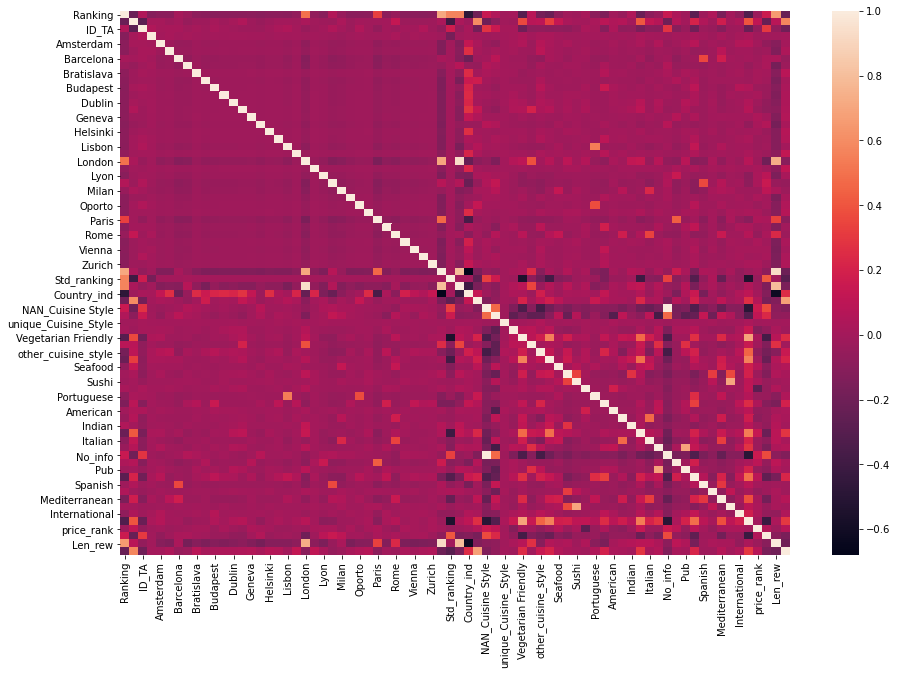

In [607]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

In [608]:

data.corr()

,Ranking,Number_of_Reviews,ID_TA,sample,Rating,Amsterdam,Athens,Barcelona,Berlin,Bratislava,...,Spanish,Chinese,Mediterranean,Japanese,International,count_Cuisine_Style,price_rank,Last_rew_data,Len_rew,Std_num_rew
Ranking,1.000000,-0.217376,0.049756,0.006271,-0.109897,-0.094100,-0.094479,0.015683,-0.026436,-0.075731,...,-0.017153,0.047129,-0.147984,-0.000338,-0.070473,-0.322408,-0.026334,0.163821,0.658182,-0.232329
Number_of_Reviews,-0.217376,1.000000,-0.284098,0.002790,0.011626,0.014759,-0.012847,0.008504,-0.048738,-0.020242,...,0.050612,-0.014394,0.179481,0.003894,0.041856,0.403259,0.109645,-0.226769,0.084249,0.578057
ID_TA,0.049756,-0.284098,1.000000,-0.000315,0.049589,0.013201,0.022209,0.022178,-0.009061,0.012232,...,-0.028809,-0.037367,-0.109303,-0.021809,-0.015737,-0.220469,-0.061790,0.310678,-0.058565,-0.196850
sample,0.006271,0.002790,-0.000315,1.000000,0.936543,-0.003550,0.002912,0.003577,-0.001989,-0.001727,...,0.006544,-0.003521,0.002891,-0.006341,0.002881,-0.003202,-0.003419,-0.001064,0.003593,-0.003142
Rating,-0.109897,0.011626,0.049589,0.936543,1.000000,0.007447,0.016852,-0.000703,0.012834,-0.002550,...,-0.002147,-0.021039,0.018614,-0.010047,0.011148,0.034506,-0.012176,-0.007779,-0.006891,0.007586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
count_Cuisine_Style,-0.322408,0.403259,-0.220469,-0.003202,0.034506,0.064104,-0.000820,0.007978,-0.045732,-0.019017,...,0.089345,0.013792,0.383432,0.103414,0.183671,1.000000,0.002816,-0.417551,0.033537,0.302433
price_rank,-0.026334,0.109645,-0.061790,-0.003419,-0.012176,-0.003031,-0.023953,-0.014778,-0.009564,0.011952,...,0.007876,-0.053128,0.018788,0.031982,0.041353,0.002816,1.000000,0.061518,-0.022929,0.079380
Last_rew_data,0.163821,-0.226769,0.310678,-0.001064,-0.007779,-0.063624,-0.012994,0.024041,0.033302,0.003380,...,-0.018395,-0.021603,-0.182432,-0.036554,-0.051778,-0.417551,0.061518,1.000000,-0.100436,-0.160065
Len_rew,0.658182,0.084249,-0.058565,0.003593,-0.006891,-0.104842,-0.128119,0.029723,-0.173398,-0.102737,...,-0.007509,0.031003,0.020648,0.017111,-0.059543,0.033537,-0.022929,-0.100436,1.000000,-0.194693


In [609]:
pd.options.display.max_info_columns 
data.info(verbose=True, max_cols=False, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 75 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Ranking               50000 non-null  float64
 1   Number_of_Reviews     50000 non-null  float64
 2   ID_TA                 50000 non-null  float64
 3   sample                50000 non-null  int64  
 4   Rating                50000 non-null  float64
 5   Amsterdam             50000 non-null  uint8  
 6   Athens                50000 non-null  uint8  
 7   Barcelona             50000 non-null  uint8  
 8   Berlin                50000 non-null  uint8  
 9   Bratislava            50000 non-null  uint8  
 10  Brussels              50000 non-null  uint8  
 11  Budapest              50000 non-null  uint8  
 12  Copenhagen            50000 non-null  uint8  
 13  Dublin                50000 non-null  uint8  
 14  Edinburgh             50000 non-null  uint8  
 15  Geneva             

In [610]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [611]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [612]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 74), (40000, 74), (40000, 73), (32000, 73), (8000, 73))

# Model 
Сам ML

In [613]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [614]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [615]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [616]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19840562499999997


<AxesSubplot:>

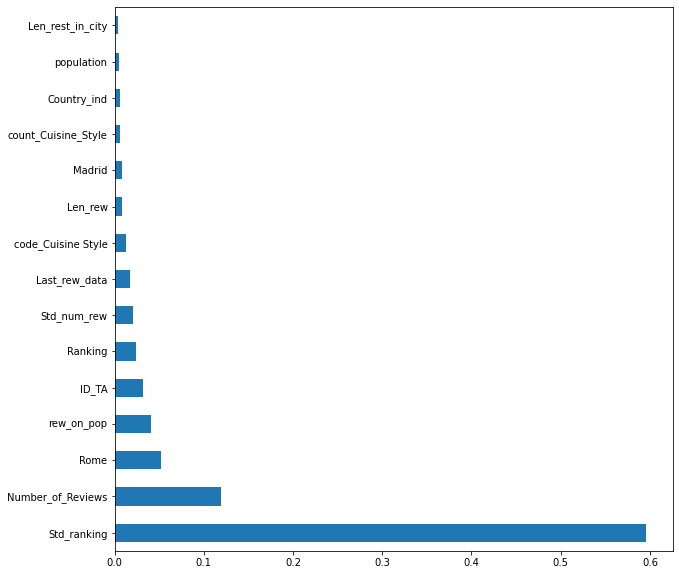

In [617]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [618]:
test_data.sample(10)
test_data = test_data.drop(['Rating'], axis=1)

In [619]:
len(test_data)

10000

In [620]:
len(sample_submission)

10000

In [621]:
predict_submission = model.predict(test_data)

len(predict_submission)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


10000

In [622]:
def round_nearest(x, a):
    return round(x / a) * a

sample_submission['Rating'] = predict_submission.round(1)
sample_submission['Rating'] = round_nearest(sample_submission['Rating'], 0.5)


sample_submission.head(10)

sample_submission.to_csv('submission.csv', index=False)